In [232]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import random

In [233]:
# #读取MNIST数据集,数据集路径为"C:\Users\29943\Desktop\模式识别\实验数据集\MNIST"，数据格式为.ubyte
# def load_mnist(path, kind='train'):

#     """Load MNIST data from `path`"""
#     labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
#     images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)

#     with gzip.open(labels_path, 'rb') as lbpath:
#         labels = np.frombuffer(lbpath.read(),dtype=np.uint8,offset=8)

#     with gzip.open(images_path, 'rb') as imgpath:
#         images = np.frombuffer(imgpath.read(),dtype=np.uint8,offset=16).reshape(len(labels), 784)

#     return images, labels

# #读取MNIST数据集
# X_train, y_train = load_mnist('C:/Users/29943/Desktop/MINST/', kind='train')
# X_test, y_test = load_mnist('C:/Users/29943/Desktop/MINST/', kind='t10k')

# #将数据集中的数据转换为DataFrame格式
# df = pd.DataFrame(X_train)
# df['label'] = y_train

# #将数据集中的数据转换为DataFrame格式
# df_test = pd.DataFrame(X_test)
# df_test['label'] = y_test

# #将数据集中的数据转换为Dataloader格式
# from torch.utils.data import DataLoader, TensorDataset
# train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
# test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
# train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
# test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=True)


mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False, num_workers=2)


#对数据进行清洗，去掉值为nan的数据


In [234]:
#softmax函数
def Softmax(x):
    return torch.exp(x) / (torch.sum(torch.exp(x), dim=1).view(-1, 1)+1e-6)

In [235]:
W = torch.normal(0, 0.01, size=(784, 10), requires_grad=True)
b = torch.zeros(10, requires_grad=True)

W1 = torch.normal(0, 0.01, size=(784, 128), requires_grad=True)
b1 = torch.zeros(128, requires_grad=True)
W2 = torch.normal(0, 0.01, size=(128, 10), requires_grad=True)
b2 = torch.zeros(10, requires_grad=True)

def model(x):
    x = x.reshape(-1, 784)
    y = torch.matmul(x, W) + b 
    return Softmax(y)

def model_2(x):
    x = x.reshape(-1, 784)
    y = torch.matmul(x, W1) + b1 
    y = torch.relu(y)
    y = torch.matmul(y, W2) + b2 
    return Softmax(y)

In [236]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, dim=1)
    cmp = y_hat.type(y.dtype) == y
    return float(torch.sum(cmp.type(y.dtype)))

def evaluate_accuracy(data_loader, net):
    acc_sum, n = 0.0, 0
    for x, y in data_loader:
        pred = net(x)
        acc_sum += accuracy(pred, y)
        n += 1
    return acc_sum / n

In [237]:
#交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y]).mean()

In [238]:
#训练函数
def train(net, train_loader, test_loader, loss, num_epochs, updater):
    loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for x, y in train_loader:
            y_hat = net(x)
            l = loss(y_hat, y).sum()
            l.requires_grad_(True)  
            updater.zero_grad()
            l.backward()
            updater.step()
            train_loss_sum += l
            train_acc_sum += accuracy(y_hat, y)
            n += x.shape[0]
        test_acc = evaluate_accuracy(test_loader, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_loss_sum / n, train_acc_sum / n, test_acc/100))
        loss_list.append(train_loss_sum / n)
        train_accuracy_list.append(train_acc_sum / n)
        test_accuracy_list.append(test_acc/100)
    return net, loss_list, train_accuracy_list, test_accuracy_list



In [239]:
def test(net, test_loader):
    '''测试模型，随机抽取10张图片，输出预测结果和实际结果以及图片'''
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        indices = random.sample(range(len(images)), 10)
        images, labels = images[indices], labels[indices]
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(10):
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title(f"Predicted: {predicted[i]}, Actual: {labels[i]}")
            plt.show()



epoch 1, loss 0.0037, train acc 0.893, test acc 0.910
epoch 2, loss 0.0030, train acc 0.914, test acc 0.915
epoch 3, loss 0.0029, train acc 0.918, test acc 0.920
epoch 4, loss 0.0028, train acc 0.920, test acc 0.921
epoch 5, loss 0.0028, train acc 0.921, test acc 0.920
epoch 6, loss 0.0028, train acc 0.922, test acc 0.920
epoch 7, loss 0.0028, train acc 0.923, test acc 0.921
epoch 8, loss 0.0027, train acc 0.923, test acc 0.923
epoch 9, loss 0.0027, train acc 0.925, test acc 0.917
epoch 10, loss 0.0027, train acc 0.924, test acc 0.925


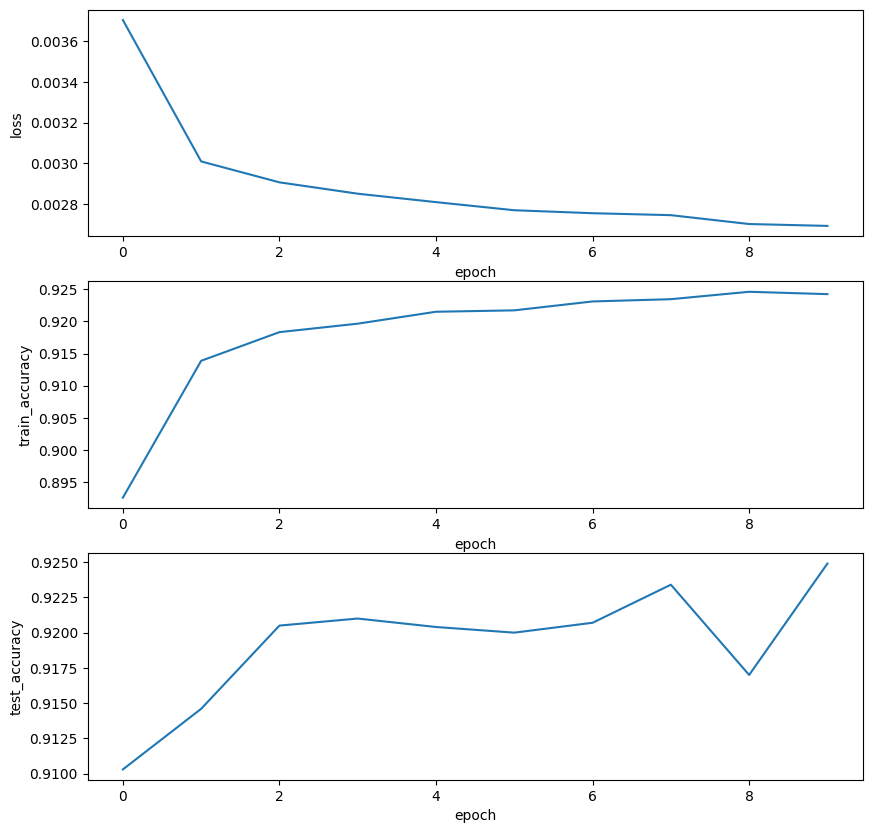

In [240]:
#开始训练
num_inputs = 784
num_outputs = 10
num_epochs = 10
lr = 0.1
loss = cross_entropy
updater = torch.optim.SGD([W, b], lr=lr, momentum=0.9)
net = model
net, loss_list, train_accuracy_list, test_accuracy_list = train(net, train_loader, test_loader, loss, num_epochs, updater)

#将tensor转换为array
loss_list = [i.detach().numpy() for i in loss_list]

#分别绘制损失函数、训练集准确率、测试集准确率随迭代次数的变化图，横坐标为迭代次数，纵坐标为损失函数、准确率，分别画在三张子图中
plt.figure(figsize=(10, 10))
plt.subplot(311)
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(312)
plt.plot(train_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('train_accuracy')
plt.subplot(313)
plt.plot(test_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
plt.show()





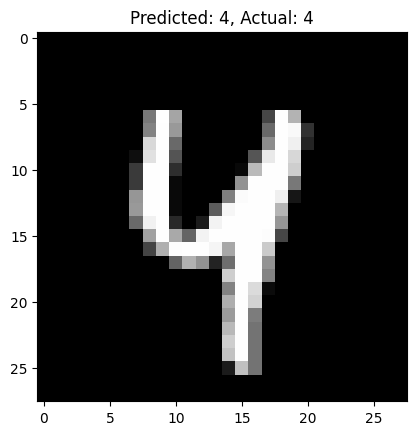

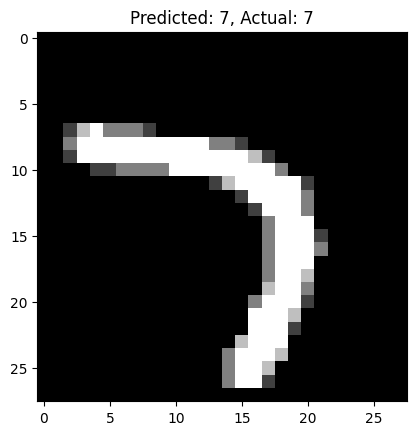

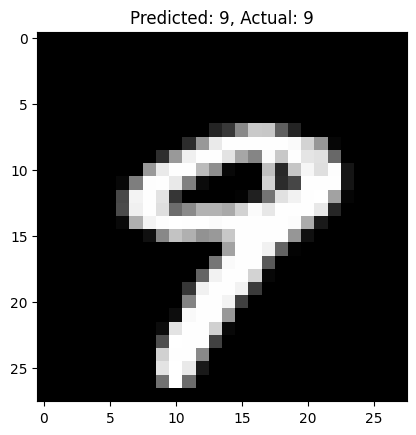

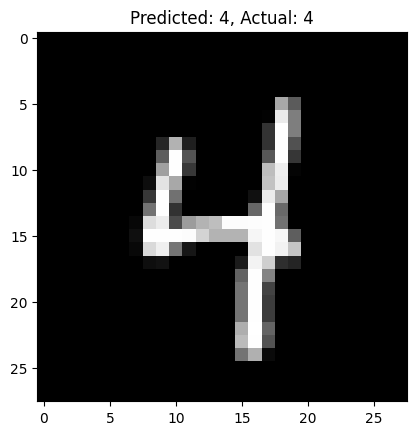

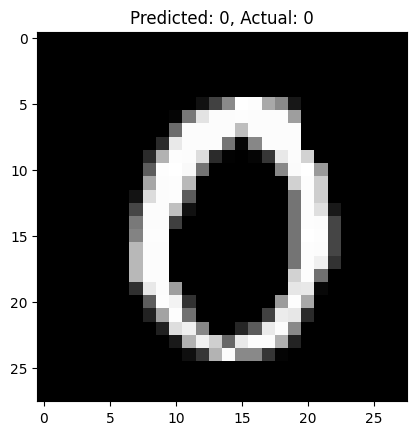

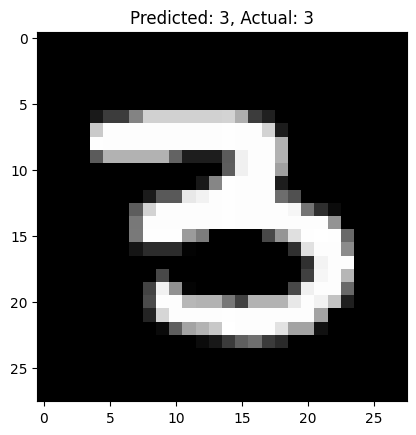

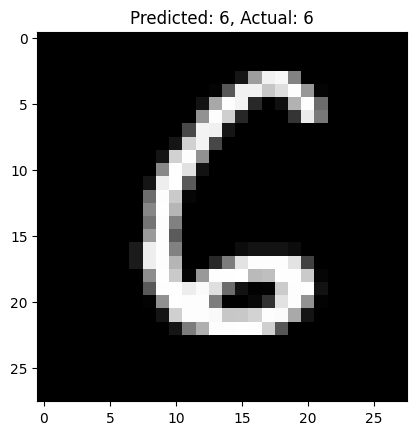

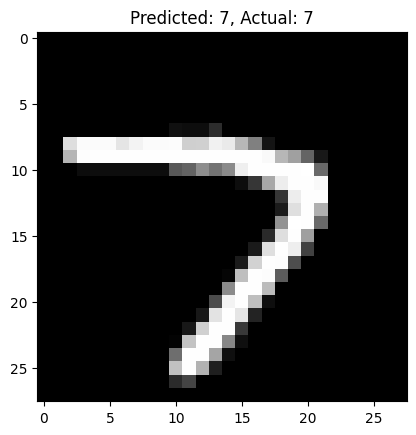

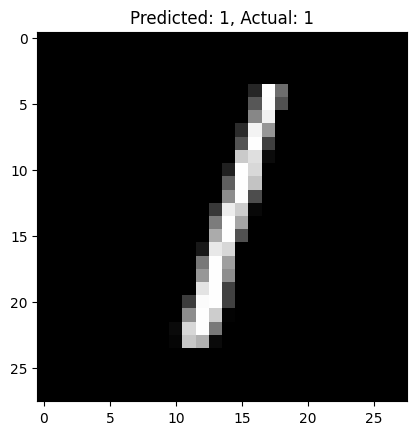

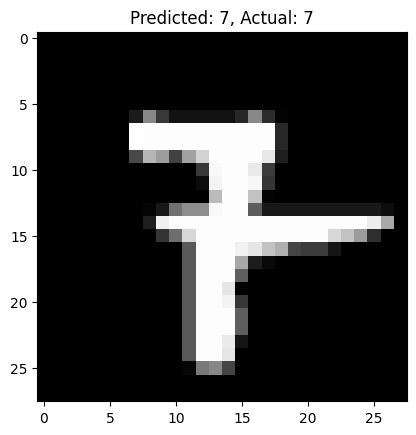

In [241]:
test(net, test_loader)